# GradCAM

In [4]:
from google.colab import drive
from os import path
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_root = './drive/MyDrive/NAS/CSED538/'
print(path.exists(data_root))

True


In [6]:
!cp -R ./drive/MyDrive/NAS/CSED538/DL20 ./data

## **Utils**
Cells below implement useful functions that will be used in this assignment

### Utils (module)

In [7]:
import wheel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import functools
import urllib
import cv2
import numpy as np
import os
import sys
import math
import random
import matplotlib.pyplot as plt
from glob import glob
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO

import PIL.Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Utils (image converter)

In [8]:
def image_tensor_to_numpy(tensor_image):
  # If this is already a numpy image, just return it
  if type(tensor_image) == np.ndarray:
    return tensor_image
  
  # Make sure this is a tensor and not a variable
  if type(tensor_image) == Variable:
    tensor_image = tensor_image.data
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor_image.detach().cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img

def image_numpy_to_tensor(np_image):
  if len(np_image.shape) == 3:
    np_image = np_image[np.newaxis, ...]
  
  # Convert from BxHxWxC (OpenCV/numpy) to BxCxHxW (PyTorch)
  np_image = np_image.transpose(0, 3, 1, 2)
  
  tensor_image = torch.from_numpy(np_image).float()
  
  return tensor_image

### Utils (image drawer)

In [9]:
def normalize(tensor):
  x = tensor - tensor.min()
  x = x / (x.max() + 1e-9)
  return x

def draw_border(image_np, color):
  color = np.asarray(color)
  s = image_np.shape
  image_np = image_np.copy()
  image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
  image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
  return image_np

def show_image(image, title=None):
  np_img = image_tensor_to_numpy(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize(np_img)
  
  # plot 
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()
    
def show_images(image_list):
  for l in image_list:
    f, axarr = plt.subplots(1,len(l))
    for i,img in enumerate(l):
      np_img = image_tensor_to_numpy(img)
      if len(np_img.shape) > 3:
        np_img = np_img[0]
      np_img = normalize(np_img)

      np_img = np_img.squeeze()
      axarr[i].imshow(np_img)
      axarr[i].axis('off')
    plt.show()

## **Model definition**
Below are the cells implementing customed-VGG11 for this assignment. You have seen this architecture in assignment_1.1. We have modified the skeleton codes slightly to access modules directly by defining the shortcut_modules attribute.

In [10]:
class VGG11BackBone(nn.Module):
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

class VGG11Classification(nn.Module):
  def __init__(self, num_classes = 7):
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.gap      = nn.AdaptiveAvgPool2d(1)
    self.fc_out   = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.backbone.pool5(x)

    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

In [11]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import glob
from PIL import Image

class LoadDataset(Dataset):
    def __init__(self, data_path, transform, mode='train'):
        super(LoadDataset, self).__init__()
        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        
        if mode == "test":
            self.test_load()
        else : 
            self.load_dataset()

    def test_load(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = glob.glob(root+"/*.png")
        
    def load_dataset(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = ImageFolder(root=root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == "test":
            img = Image.open(self.data[index]).convert('RGB')
            img = self.transform(img)
            return img
        else:
            img, label = self.data[index]
            img, label = self.transform(img), int(label)
            return img, label

In [13]:
data_root = './data'

input_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

mask_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)

In [ ]:
save_feat=[]
def hook_feat(module, input, output):
  save_feat.append(output)
  return output

save_grad=[]
def hook_grad(grad):
  """
  get a gradient from intermediate layers (dy / dA).
  See the .register-hook function for usage.
  :return grad: (Variable) gradient dy / dA
  """ 
  save_grad.append(grad)
  return grad

def vis_gradcam(vgg, img):
  """
  Imshow the grad_CAM.
  :param vgg: VGG11Customed model
  :param img: a dog image
  output : plt.imshow(grad_CAM)
  """
  vgg.eval()

  # Reister hook for storing layer activation of the target layer (bn5_2 in backbone)
  vgg.backbone.bn5_2.register_forward_hook(hook_feat)
  
  # Forward pass to hook features
  img = img.unsqueeze(0)
  s = vgg(img)[0]

  # Register hook for storing gradients
  save_feat[0].register_hook(hook_grad)
  
  # Backward score
  y = torch.argmax(s).item()
  s_y = s[y]
  s_y.backward()

  # Compute activation at global-average-pooling layer
  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0])
  A = save_feat[0].squeeze()

  # Compute grad_CAM
  relu_layer = torch.nn.ReLU()
  
  weighted_sum = torch.sum(alpha*A, dim=0)
  grad_CAM = relu_layer(weighted_sum)

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  # Upscale grad_CAM
  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')
  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = grad_CAM/torch.max(grad_CAM)

  # Plotting
  img_np = image_tensor_to_numpy(img)
  if len(img_np.shape) > 3:
    img_np = img_np[0]
  img_np = normalize(img_np)
  
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(img_np)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
  plt.show

  return grad_CAM

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


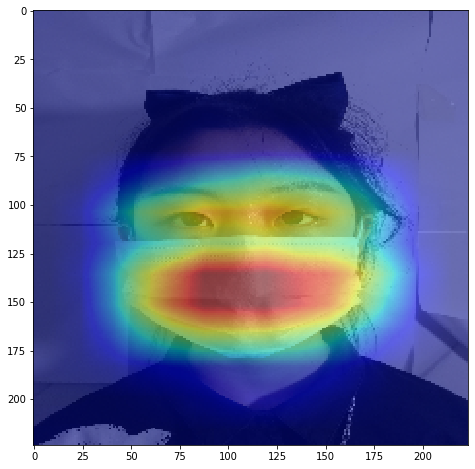

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

img = mask_dataset[1]
res = vis_gradcam(model, img)